<a href="https://colab.research.google.com/github/Sadat-Shakeeb/california-housing-price-prediction/blob/main/housing_value_prediction_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import joblib

**1. Load Dataset**

In this step, we load the California Housing dataset using fetch_california_housing(as_frame=True).
The dataset contains various features related to California districts (e.g., median income, house age, population) and the target variable MedHouseVal representing median house value.

The .frame attribute gives us the dataset as a pandas DataFrame, making it easy to inspect and work with.

In [21]:
data=fetch_california_housing(as_frame=True)
df = data.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [23]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [24]:
df.isna().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


In [25]:
df = df.drop_duplicates()

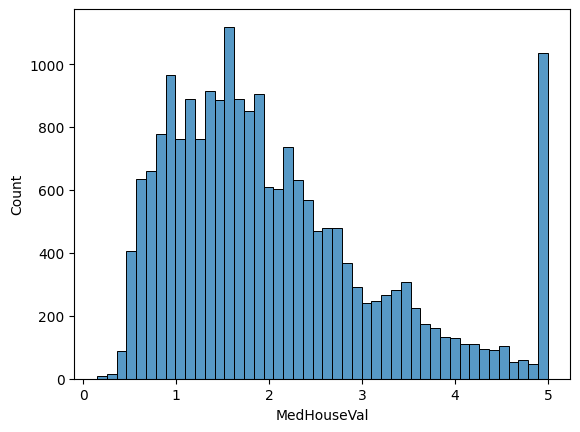

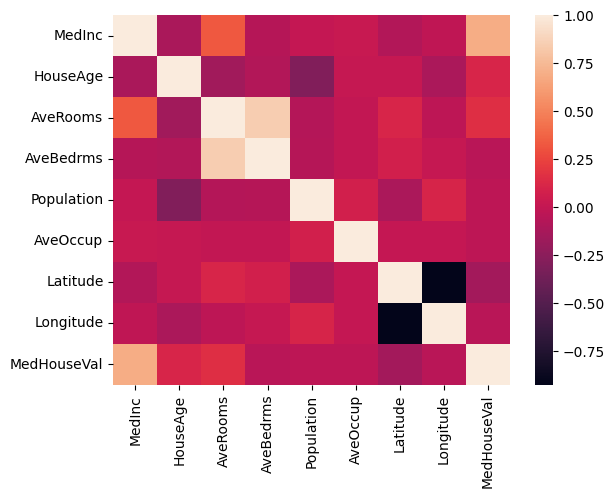

In [26]:
sns.histplot(df['MedHouseVal'])
plt.show()
sns.heatmap(df.corr(), annot=False)
plt.show()

In [27]:
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']


**2. Train-Test Split**

Here we split the dataset into training and test sets using 80% for training and 20% for testing.
The training set is used to build the models, and the test set is kept aside to evaluate generalization performance.

random_state=42 ensures reproducibility.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


**3. Build Full Preprocessing + Ridge Pipeline**

We create a Pipeline that automates:

Missing-value imputation (SimpleImputer)

Feature scaling (StandardScaler)

Feature selection (SelectKBest)

Ridge regression

Using a pipeline helps ensure clean, reproducible preprocessing and prevents data leakage.

In [29]:
lin_pipe=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scalar',StandardScaler()),
    ('select',SelectKBest(score_func=f_regression,k=6)),
    ('model',LinearRegression())
])

ridge_pipe=Pipeline([
    ('imputer',SimpleImputer()),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_regression, k=6)),
    ("model", Ridge(alpha=1.0))
])

rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(random_state=42))
])

In [30]:
lin_pipe.fit(X_train,y_train)
ridge_pipe.fit(X_train,y_train)
rf_pipe.fit(X_train,y_train)

y_pred_lin = lin_pipe.predict(X_test)
y_pred_ridge = ridge_pipe.predict(X_test)
y_pred_rf = rf_pipe.predict(X_test)


**4. Baseline Models (Linear, Ridge, Random Forest)**

We train three baseline regression models:

Linear Regression: A basic linear model without regularization.

Ridge Regression: Linear model with L2 regularization, which helps reduce coefficient magnitude and control overfitting.

RandomForestRegressor: A tree-based ensemble model that typically performs very well on tabular datasets.

Linear: R2 = 0.5749693819995386, RMSE = 0.7463001660559125  
Ridge:  R2 = 0.5749977945514843, RMSE = 0.7462752212099223  
RF:     R2 = 0.8051230593157366, RMSE = 0.5053399773665033  

Interpretation:

Linear and Ridge give similar performance.

Random Forest significantly outperforms the linear models with R² = 0.805 and a much lower RMSE.

This gives us a benchmark before tuning the Ridge model further.

In [31]:
def print_metrics(name,y_true,y_pred):
  print(name,r2_score(y_true,y_pred), np.sqrt(mean_squared_error(y_true, y_pred)))

print_metrics('Linear',y_test,y_pred_lin)
print_metrics("Ridge", y_test, y_pred_ridge)
print_metrics("RF", y_test, y_pred_rf)

Linear 0.5749693819995386 0.7463001660559125
Ridge 0.5749977945514843 0.7462752212099223
RF 0.8051230593157366 0.5053399773665033


**5. Ridge Cross-Validation**

To evaluate Ridge more robustly, we run 5-fold cross-validation on the training set.

This splits the training set into 5 folds, trains on 4, and validates on 1, rotating through all folds.
The goal is to check stability and detect overfitting.

CV Results
Ridge CV R2 scores:
[0.55722286, 0.46693596, 0.55175024, 0.53689198, 0.52531766]

Mean CV R² = 0.5276237392612451

Interpretation:

Ridge shows moderate variance across folds.

Mean CV R² ≈ 0.528, slightly lower than the test performance.

This indicates the model is relatively stable but underfits slightly.

In [41]:
scores = cross_val_score(
    ridge_pipe, X, y, cv=5, scoring="r2"
)
print("Ridge CV R2 scores:", scores)
print("Mean CV R2:", scores.mean())


Ridge CV R2 scores: [0.55722286 0.46693596 0.55175024 0.53689198 0.52531766]
Mean CV R2: 0.5276237392612451


**6. Hyperparameter Tuning with GridSearchCV**

To optimize model performance, we tune two hyperparameters:

select__k: number of features to select (4, 6, 8)

model__alpha: Ridge regularization strength (0.1, 1.0, 10.0)

GridSearchCV tries all combinations with 5-fold cross-validation and identifies the best setting.

Best Parameters

{'model__alpha': 0.1, 'select__k': 8}

Best CV R²

0.6114839657407327

Interpretation

Best Ridge regularization = alpha = 0.1

Best feature count = k = 8

CV R² improved significantly over the earlier mean CV R² (~0.528 → ~0.611)

**7. Final Test Performance of Best Ridge Model**

With the best hyperparameters selected, we evaluate the tuned model on the test set.

Results

Best Ridge (GridSearchCV):
R2 = 0.5757905180002312
RMSE = 0.7455789118982769

Interpretation

The tuned Ridge model performs similarly to the baseline Ridge.

Regularization helps stability and interpretability but does not match Random Forest performance.

Overall R² ≈ 0.576 means the linear model captures ~57% of variance.


In [44]:
param_grid = {
    'select__k' : [4,6,8],
    'model__alpha' : [0.1,1,10]
}

grid = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV R2:", grid.best_score_)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print_metrics("Best Ridge (GridSearchCV)", y_test, y_pred_best)

Best params: {'model__alpha': 0.1, 'select__k': 8}
Best CV R2: 0.6114839657407327
Best Ridge (GridSearchCV) 0.5757905180002312 0.7455789118982769


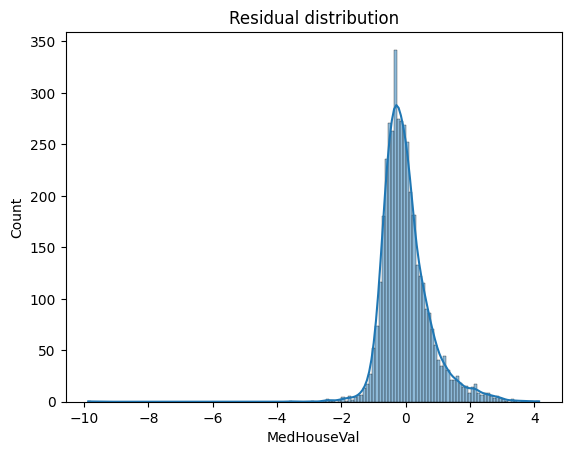

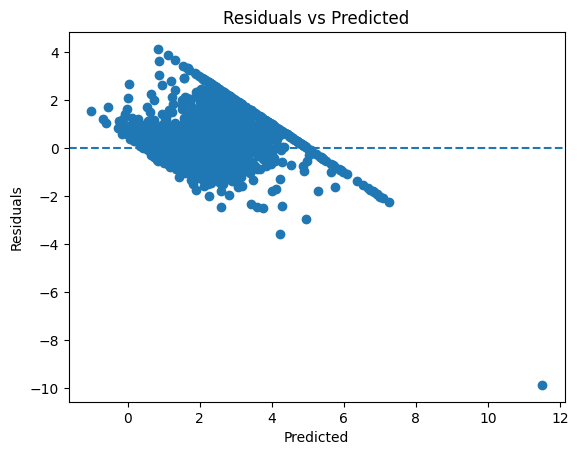

In [45]:
residuals = y_test - y_pred_best

sns.histplot(residuals, kde=True)
plt.title("Residual distribution")
plt.show()

plt.scatter(y_pred_best, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()




**8. Interpreting Coefficients (Simple Ridge Model)**

To interpret feature influence, we build a simplified Ridge pipeline without feature selection, using the best alpha value from GridSearchCV.

This ensures:

The number of coefficients = number of original features

Each coefficient directly maps to a feature

We extract:

Feature names

Corresponding coefficients

Sort them to identify most influential variables

Positive coefficient → increases predicted house price
Negative coefficient → decreases predicted house price

This step is useful for insights and reporting.

In [51]:
simple_ridge = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=grid.best_params_["model__alpha"]))
])

simple_ridge.fit(X_train, y_train)

ridge_model = simple_ridge.named_steps["model"]
feature_names = X.columns

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": ridge_model.coef_
}).sort_values(by="coefficient", ascending=False)

coef_df

,feature,coefficient
0,MedInc,0.854377
3,AveBedrms,0.339234
1,HouseAge,0.122554
4,Population,-0.002305
5,AveOccup,-0.040829
2,AveRooms,-0.294390
7,Longitude,-0.869765
6,Latitude,-0.896853


**Coefficient interpretation:**

The strongest positive predictor of house value is MedInc (median income), confirming that wealthier areas correspond to higher median home prices.

The strongest negative predictors are Latitude and Longitude, indicating that location plays a large role: moving inland (away from the California coast) decreases house prices significantly.

AveRooms shows a negative coefficient due to multicollinearity with AveBedrms, a known issue in this dataset, but does not imply that more rooms reduce prices.

**9. Save Best Model**

We save the fully-tuned pipeline model to:

best_house_price_model.pkl

This model can later be loaded directly for inference or deployment using:

loaded_model = joblib.load("best_house_price_model.pkl")
preds = loaded_model.predict(new_data)


In [49]:
import joblib

joblib.dump(best_model, "best_house_price_model.pkl")


['best_house_price_model.pkl']